In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/facial-expression/fer2013.csv
/kaggle/input/facial-expression/fer2013/fer2013.csv


In [2]:
import pandas as pd
faces = pd.read_csv("../input/facial-expression/fer2013.csv")

In [3]:
faces.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
faces['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [6]:
from keras.models import Sequential
from keras.layers import BatchNormalization,Conv2D,Dense,Dropout,AvgPool2D,Flatten
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [8]:
Y_all=np.asarray(faces['emotion'])
#X_all=np.asarray(faces.drop(columns=['emotion','Usage']))
lis=[]
for i in range(faces['emotion'].count()):
    lis.append(list(map(lambda x: int(x),faces['pixels'].loc[i].split())))
X_all=np.asarray(lis)

In [9]:
X_all=X_all.reshape(-1,48,48,1)

In [10]:
Y=np.zeros((X_all.shape[0],7))
for i in range(35887):
    Y[i][Y_all[i]]=1
Y_all=Y

In [11]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [12]:
def show_img(X_all,Y_all,index):
    print(emotions[np.argmax(Y_all[index])])
    plt.imshow(X_all[index,:,:,0],cmap='gray')

In [13]:
X_train,X_val,Y_train,Y_val=train_test_split(X_all,Y_all,test_size=0.15,random_state=23)

Happy


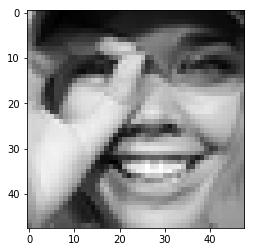

In [14]:
show_img(X_train,Y_train,8346)

In [15]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(30503, 48, 48, 1)
(5384, 48, 48, 1)
(30503, 7)
(5384, 7)


In [16]:
def create_model():
    
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=16,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=32,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(Dropout(0,25))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=64,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=(4,4),padding='same',activation='relu'))
    model.add(AvgPool2D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    
    return model

In [ ]:
#to use tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model=create_model()
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
#normal execution
model=create_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [20]:
epoch=200
batch_size=128

In [21]:
model.fit(X_train,Y_train,epochs=1)
History=model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),validation_data=(X_val,Y_val),epochs=epoch,steps_per_epoch=X_train.shape[0]//batch_size)

Epoch 1/1
30503/30503 [==============================] - 20s 656us/step - loss: 1.7300 - accuracy: 0.2975
Epoch 1/200
238/238 [==============================] - 15s 62ms/step - loss: 1.5293 - accuracy: 0.3996 - val_loss: 1.5252 - val_accuracy: 0.3975
Epoch 2/200
238/238 [==============================] - 14s 59ms/step - loss: 1.4294 - accuracy: 0.4445 - val_loss: 1.3548 - val_accuracy: 0.4655
Epoch 3/200
238/238 [==============================] - 14s 58ms/step - loss: 1.3619 - accuracy: 0.4780 - val_loss: 1.3159 - val_accuracy: 0.4918
Epoch 4/200
238/238 [==============================] - 14s 61ms/step - loss: 1.3145 - accuracy: 0.4981 - val_loss: 1.2444 - val_accuracy: 0.5173
Epoch 5/200
238/238 [==============================] - 14s 59ms/step - loss: 1.2601 - accuracy: 0.5183 - val_loss: 1.2494 - val_accuracy: 0.5256
Epoch 6/200
238/238 [==============================] - 14s 59ms/step - loss: 1.2339 - accuracy: 0.5288 - val_loss: 1.2085 - val_accuracy: 0.5392
Epoch 7/200
238/238 [===

238/238 [==============================] - 14s 60ms/step - loss: 0.8485 - accuracy: 0.6838 - val_loss: 0.9902 - val_accuracy: 0.6436
Epoch 57/200
238/238 [==============================] - 13s 56ms/step - loss: 0.8536 - accuracy: 0.6829 - val_loss: 0.9920 - val_accuracy: 0.6451
Epoch 58/200
238/238 [==============================] - 13s 56ms/step - loss: 0.8490 - accuracy: 0.6857 - val_loss: 1.0237 - val_accuracy: 0.6231
Epoch 59/200
238/238 [==============================] - 13s 57ms/step - loss: 0.8414 - accuracy: 0.6867 - val_loss: 0.9723 - val_accuracy: 0.6467
Epoch 60/200
238/238 [==============================] - 15s 62ms/step - loss: 0.8459 - accuracy: 0.6862 - val_loss: 0.9531 - val_accuracy: 0.6480
Epoch 61/200
238/238 [==============================] - 13s 57ms/step - loss: 0.8407 - accuracy: 0.6890 - val_loss: 0.9891 - val_accuracy: 0.6452
Epoch 62/200
238/238 [==============================] - 13s 57ms/step - loss: 0.8358 - accuracy: 0.6905 - val_loss: 0.9533 - val_accuracy

238/238 [==============================] - 14s 60ms/step - loss: 0.7504 - accuracy: 0.7224 - val_loss: 0.9685 - val_accuracy: 0.6534
Epoch 113/200
238/238 [==============================] - 14s 59ms/step - loss: 0.7343 - accuracy: 0.7281 - val_loss: 0.9928 - val_accuracy: 0.6458
Epoch 114/200
238/238 [==============================] - 14s 58ms/step - loss: 0.7510 - accuracy: 0.7231 - val_loss: 0.9820 - val_accuracy: 0.6558
Epoch 115/200
238/238 [==============================] - 14s 58ms/step - loss: 0.7389 - accuracy: 0.7265 - val_loss: 0.9759 - val_accuracy: 0.6575
Epoch 116/200
238/238 [==============================] - 14s 59ms/step - loss: 0.7416 - accuracy: 0.7260 - val_loss: 1.0304 - val_accuracy: 0.6393
Epoch 117/200
238/238 [==============================] - 14s 60ms/step - loss: 0.7424 - accuracy: 0.7277 - val_loss: 1.0001 - val_accuracy: 0.6352
Epoch 118/200
238/238 [==============================] - 13s 56ms/step - loss: 0.7367 - accuracy: 0.7296 - val_loss: 0.9921 - val_ac

238/238 [==============================] - 14s 58ms/step - loss: 0.6872 - accuracy: 0.7445 - val_loss: 0.9674 - val_accuracy: 0.6620
Epoch 168/200
238/238 [==============================] - 14s 59ms/step - loss: 0.6841 - accuracy: 0.7459 - val_loss: 0.9690 - val_accuracy: 0.6690
Epoch 169/200
238/238 [==============================] - 13s 56ms/step - loss: 0.6844 - accuracy: 0.7486 - val_loss: 1.0020 - val_accuracy: 0.6516
Epoch 170/200
238/238 [==============================] - 14s 58ms/step - loss: 0.6870 - accuracy: 0.7499 - val_loss: 0.9649 - val_accuracy: 0.6683
Epoch 171/200
238/238 [==============================] - 13s 56ms/step - loss: 0.6816 - accuracy: 0.7489 - val_loss: 0.9888 - val_accuracy: 0.6607
Epoch 172/200
238/238 [==============================] - 14s 59ms/step - loss: 0.6803 - accuracy: 0.7500 - val_loss: 1.0385 - val_accuracy: 0.6599
Epoch 173/200
238/238 [==============================] - 13s 56ms/step - loss: 0.6841 - accuracy: 0.7453 - val_loss: 1.0230 - val_ac

KeyboardInterrupt: 

In [37]:
predictions_val=model.predict(X_val)
predictions_train=model.predict(X_train)

In [30]:
pred_classes=np.argmax(predictions,axis=1)
Y_org_val=[]
for i in Y_val:
    Y_org_val.append(np.argmax(i))

In [36]:
np.sum(pred_classes==Y_org_val)/pred_classes.shape[0]

0.6580609212481426

NameError: name 'History' is not defined

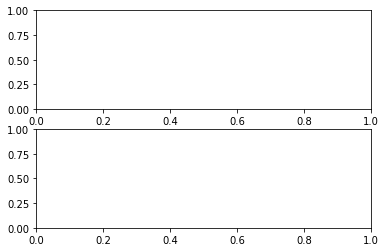

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(History.history['loss'], color='b', label="Training loss")
ax[0].plot(History.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(History.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(History.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Happy
Index:  114
Prediction: [[0.5613103  0.00623978 0.18974547 0.10160477 0.05466196 0.04138241
  0.04505533]]
Predicted class is : Angry


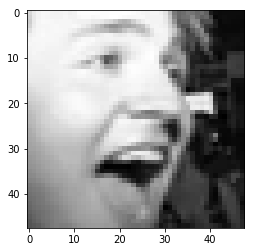

In [44]:
for i in range(115,X_val.shape[0]):
    pred=model.predict(X_val[i].reshape((1,48,48,1)))
    if(np.argmax(pred)!=np.argmax(Y_val[i])):
        show_img(X_val,Y_val,i)
        print('Index: ',i)
        print('Prediction:',pred)
        print('Predicted class is :',emotions[np.argmax(pred)])
        break

In [ ]:
val=model.predict(X_val[1].reshape((1,48,48,1)))
print(emotions[np.argmax(val)])
print(val)
print(Y_val[0])
print(np.argmax(val)!=np.argmax(Y_val[i]))